In [2]:
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

from preprocessor import AtomDataset
from randomizer import augment_data

torch.manual_seed(114514)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
dataset = AtomDataset(root='./', threshold=2.0)
data = dataset._data
print(data)

Data(x=[220, 6], edge_index=[2, 544], y=[220, 1])


In [4]:
augmented_dataset, original_ys = augment_data(data=data, num_new_data=50000, position_noise=0.05, moment_noise=1)

In [5]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, g_hidden_channels, fc_hidden_channels, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, g_hidden_channels)
        self.conv2 = GCNConv(g_hidden_channels, g_hidden_channels)
        self.conv3 = GCNConv(g_hidden_channels, g_hidden_channels)
        
        self.fc1 = Linear(g_hidden_channels, fc_hidden_channels)
        self.fc2 = Linear(fc_hidden_channels, fc_hidden_channels)
        self.fc3 = Linear(fc_hidden_channels, out_channels)

        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        # x: (num_nodes, in_channels)
        # edge_index: (2, E)
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.fc1(x)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)
        
        return x
    
    def save_model(self, file_path: str = 'gnn_model.pt'):
        torch.save(self.state_dict(), file_path)
        print(f'Model saved to {file_path}.')

    @staticmethod
    def load_model(file_path: str,
                   in_channels: int,
                   g_hidden_channels: int,
                   fc_hidden_channels: int,
                   out_channels: int,
                   dropout=0.0):
        model = GNNModel(in_channels, g_hidden_channels, fc_hidden_channels, out_channels, dropout)
        model.load_state_dict(torch.load(file_path, map_location='cpu'))
        print(f'Model loaded from {file_path}.')
        return model

In [6]:
ATOM_TYPE_DICT = {
    'N': 0,
    'C': 1,
    'O': 2,
}

atom2color = {
    0: 'red',   # nitrogen
    1: 'blue',  # carbon
    2: 'green'  # oxygen
}

def plot_atom_data(fig,
                   data: Data,
                   y_pred: torch.Tensor,
                   cmap_name: str = 'coolwarm',
                   size_scale: float = 40.0,
                   size_offset: float = 5.0,
                   legend_moments: list = None):
    coords = data.x[:, -3:].cpu().numpy()
    bonds = data.edge_index.cpu().numpy()

    y_true = data.y.view(-1).cpu()
    y_pred = y_pred.view(-1).cpu()
    diff = (y_pred - y_true).detach().cpu().numpy()

    cmap = cm.get_cmap(cmap_name)
    lim = max(abs(diff.min()), abs(diff.max()))
    norm = mcolors.Normalize(vmin=-lim, vmax=+lim)

    colors = cmap(norm(diff))
    marker_sizes = 40.0 * np.abs(y_true) + 5.0

    ax = fig.add_subplot(projection='3d')
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
               c=colors, s=marker_sizes, marker='o')

    # Plot bonds
    for i in range(bonds.shape[1]):
        start, end = bonds[:, i]
        x_coords = [coords[start, 0], coords[end, 0]]
        y_coords = [coords[start, 1], coords[end, 1]]
        z_coords = [coords[start, 2], coords[end, 2]]
        ax.plot(x_coords, y_coords, z_coords, c='k', linewidth=0.8)
    
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_zlim(-10, 10)
    ax.axis('off')

    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])  # needed only for colorbar
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.65, pad=0.1)
    cbar.set_label('Error (predicted - true)', rotation=90)

    if legend_moments is None:
        # default reference moments
        legend_moments = [0.1, 0.5, 1.0]
        
    legend_elements = []
    for val in legend_moments:
        # compute the scatter 's' value
        # (Remember 's' is in points^2, so we just use the same formula.)
        size_val = size_scale * np.abs(val) + size_offset
        # We'll use a Line2D handle in place of a scatter.  
        # In matplotlib, marker sizes are in 'points' for lines, 
        # but in scatter they are 'points^2'. To match visually,
        # we take the square root if using Line2D:
        handle = Line2D(
            [], [], 
            linestyle='none', 
            marker='o', 
            markersize=np.sqrt(size_val), 
            markeredgecolor='k',
            markerfacecolor='gray',
            label=f"|y| = {val}"
        )
        legend_elements.append(handle)

    ax.legend(
        handles=legend_elements, 
        title="Marker Size vs |Mag. Moment|",
        loc='upper left', 
        bbox_to_anchor=(0.0, 0.0)
    )
    

In [7]:
train_size = int(0.8 * len(augmented_dataset))
train_dataset = augmented_dataset[:train_size]
test_dataset = augmented_dataset[train_size:]

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

model = GNNModel.load_model('gnn_model.pt',
                             in_channels=6,
                             g_hidden_channels=64,
                             fc_hidden_channels=64,
                             out_channels=1,
                             dropout=0.05,
                             )

model.to(device)
model.eval()

eval_data = copy.deepcopy(data)

with torch.no_grad():
    eval_data = eval_data.to(device)
    out = model(eval_data.x, eval_data.edge_index, None)
    out_flat = out.view(-1).cpu().numpy()
    y_flat = eval_data.y.view(-1).cpu().numpy()



Model loaded from gnn_model.pt.


C:\Users\y1hli\AppData\Local\Temp\ipykernel_27712\2678872207.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path, map_location='c

C:\Users\y1hli\AppData\Local\Temp\ipykernel_27712\4292007085.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


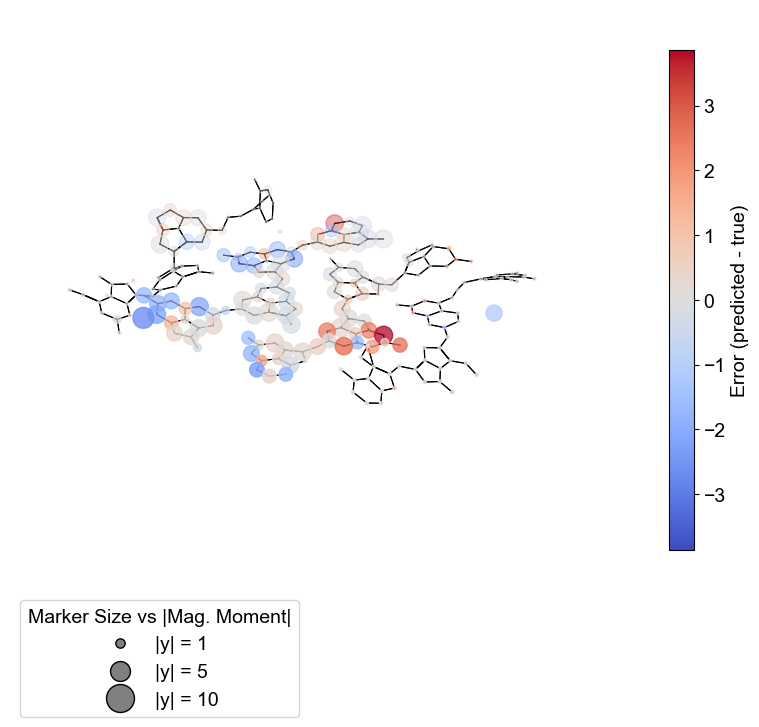

In [8]:
fig = plt.figure(figsize=(10, 10))

plot_atom_data(fig, eval_data, out, legend_moments=[1, 5, 10])
fig.savefig('eval.svg', dpi=600)

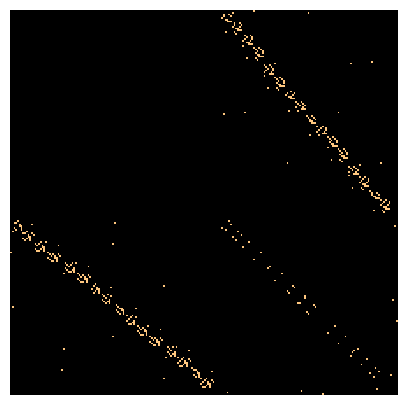

In [24]:
import seaborn as sns

num_nodes = data.x.shape[0]
adj_matrix = np.zeros((num_nodes, num_nodes), dtype=float)

edges = eval_data.edge_index.cpu().numpy()
for i in range(edges.shape[1]):
    start, end = edges[0, i], edges[1, i]
    adj_matrix[start, end] = 1.0

plt.figure(figsize=(5, 5))
ax = sns.heatmap(adj_matrix, cmap='copper', cbar=False, xticklabels=False, yticklabels=False, linewidths=0)

In [22]:
data.x[:, :3]

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1